# 📊 LSTM - Smoothed Throughput Prediction with Visualization
**Correction manuelle** : Smoothing sur `Throughput`, visualisation du run 118

---

In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

### 🔹 1. Chargement des données

In [2]:

# Chemin vers les données préparées
df = pd.read_csv(r"C:\Users\axxiv\Desktop\PI\mm-5G-prepared.csv")
df.head()


,run_num,seq_num,abstractSignalStr,latitude,longitude,movingSpeed,compassDirection,nrStatus,lte_rssi,lte_rsrp,lte_rsrq,lte_rssnr,nr_ssRsrp,nr_ssRsrq,nr_ssSinr,Throughput,mobility_mode,trajectory_direction,tower_id
0,1,1.0,2,44.975314,-93.259316,0.094889,150,0,0.642857,0.479167,0.400000,0.0,-150.0,-20.0,-30.0,78,0,1,16
1,1,2.0,2,44.975311,-93.259311,0.876634,117,0,0.642857,0.479167,0.400000,0.0,-150.0,-20.0,-30.0,117,0,1,16
2,1,3.0,2,44.975305,-93.259292,2.225798,113,0,0.642857,0.479167,0.400000,0.0,-150.0,-20.0,-30.0,110,0,1,16
3,1,4.0,2,44.975293,-93.259258,3.180726,114,0,0.714286,0.468750,0.266667,0.0,-150.0,-20.0,-30.0,108,0,1,16
4,1,5.0,2,44.975278,-93.259214,3.751234,115,0,0.714286,0.468750,0.266667,0.0,-150.0,-20.0,-30.0,100,0,1,16


### 🔹 2. Smoothing sur la colonne `Throughput`

In [3]:

df['Throughput_smoothed'] = df['Throughput'].rolling(window=5, min_periods=1).mean()


### 🔹 3. Visualisation du Run 118 : `Throughput` vs `Throughput_smoothed`

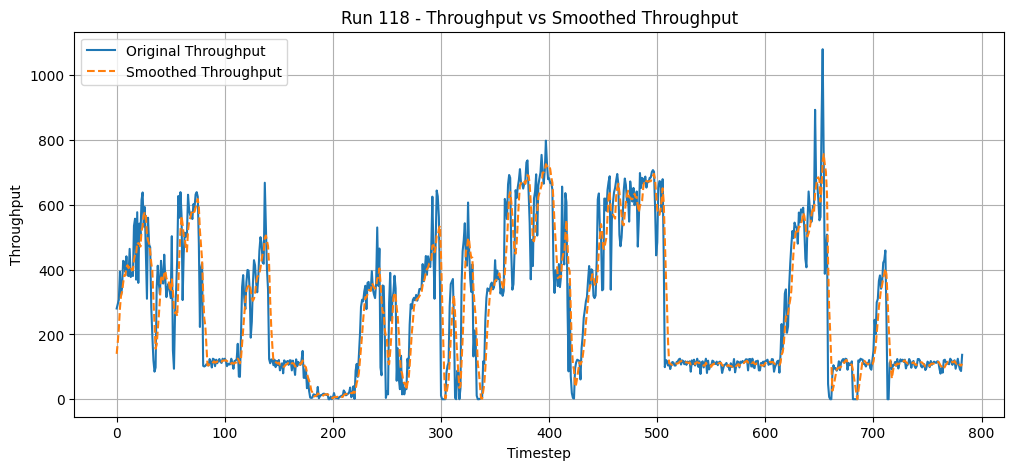

In [4]:

run_118 = df[df['run_num'] == 118]
plt.figure(figsize=(12,5))
plt.plot(run_118['Throughput'].values, label='Original Throughput')
plt.plot(run_118['Throughput_smoothed'].values, label='Smoothed Throughput', linestyle='--')
plt.title('Run 118 - Throughput vs Smoothed Throughput')
plt.xlabel('Timestep')
plt.ylabel('Throughput')
plt.legend()
plt.grid(True)
plt.show()


### 🔹 4. Création des séquences pour LSTM (avec `Throughput_smoothed` comme cible)

In [5]:

class TimeSeriesDataset(Dataset):
    def __init__(self, df, input_len=48, output_len=1):
        self.X, self.y = [], []
        features = df.columns.drop(['Throughput', 'Throughput_smoothed'])
        for i in range(len(df) - input_len - output_len + 1):
            x = df[features].iloc[i:i+input_len].values
            y = df['Throughput_smoothed'].iloc[i+input_len:i+input_len+output_len].values
            self.X.append(x)
            self.y.append(y)
        self.X = torch.tensor(np.array(self.X), dtype=torch.float32)
        self.y = torch.tensor(np.array(self.y), dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

input_len = 48
output_len = 1

dataset = TimeSeriesDataset(df, input_len, output_len)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64)


### 🔹 5. Définition et entraînement du modèle LSTM

In [9]:

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_len):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_len)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

model = LSTMModel(input_size=df.shape[1] - 2, hidden_size=64, output_len=output_len)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses, val_losses = [], []

for epoch in range(50):
    model.train()
    train_loss = 0
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_dl))

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_dl:
            pred = model(xb)
            val_loss += loss_fn(pred, yb).item()
    val_losses.append(val_loss / len(val_dl))

    print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}")


Epoch 1: Train Loss = 434032.6826, Val Loss = 407908.2265
Epoch 2: Train Loss = 388001.5184, Val Loss = 366486.4347
Epoch 3: Train Loss = 350034.7448, Val Loss = 331604.6762
Epoch 4: Train Loss = 317322.8287, Val Loss = 300985.9219
Epoch 5: Train Loss = 288196.4381, Val Loss = 273374.9982
Epoch 6: Train Loss = 262040.0530, Val Loss = 248867.6054
Epoch 7: Train Loss = 238818.1801, Val Loss = 226934.1275
Epoch 8: Train Loss = 218266.9294, Val Loss = 207920.7555
Epoch 9: Train Loss = 199941.1891, Val Loss = 190307.0759
Epoch 10: Train Loss = 183479.6307, Val Loss = 175009.8375
Epoch 11: Train Loss = 169553.7407, Val Loss = 162279.9686
Epoch 12: Train Loss = 157752.3167, Val Loss = 151587.4093
Epoch 13: Train Loss = 148531.7983, Val Loss = 145283.6380
Epoch 14: Train Loss = 140711.9656, Val Loss = 136277.0320
Epoch 15: Train Loss = 134651.9065, Val Loss = 132246.7653
Epoch 16: Train Loss = 153559.0131, Val Loss = 127096.7841
Epoch 17: Train Loss = 127487.6574, Val Loss = 124256.9078
Epoch 

### 🔹 6. Visualisation prédiction vs `Throughput` non smoothed

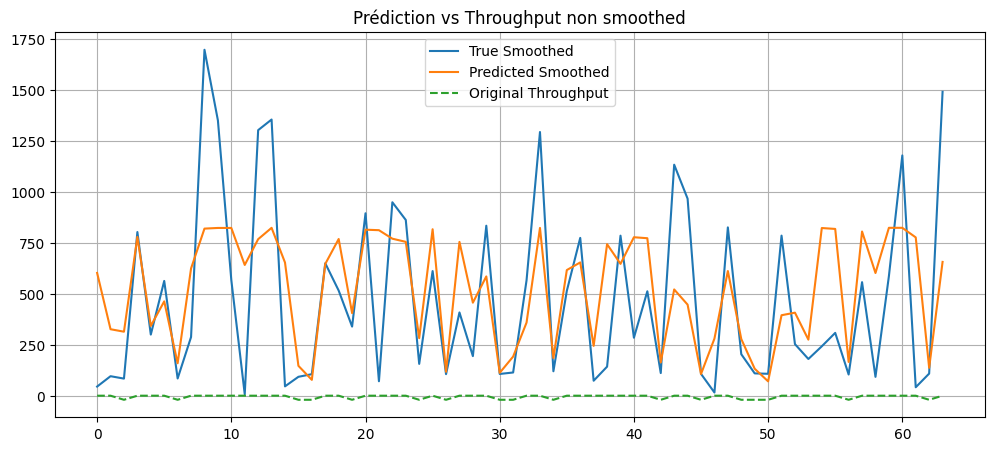

In [10]:

model.eval()
xbatch, ytrue = next(iter(val_dl))
with torch.no_grad():
    ypred = model(xbatch).squeeze().numpy()

plt.figure(figsize=(12,5))
plt.plot(ytrue.squeeze().numpy(), label='True Smoothed')
plt.plot(ypred, label='Predicted Smoothed')
plt.plot(xbatch[:, -1, df.columns.get_loc('Throughput') - 2].numpy(), label='Original Throughput', linestyle='--')
plt.title('Prédiction vs Throughput non smoothed')
plt.legend()
plt.grid(True)
plt.show()
